<a href="https://colab.research.google.com/github/jake-joseph/HRV/blob/main/Full_HRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing 
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings
import glob

In [31]:
def import_data(data):
  # Read CSV
  df = pd.read_csv(data,index_col="Time", usecols=["Time", "ECG_II",'CH1'])

  # Convert string to dates with following parser format 
  df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S.%f")

  # Convert the column data using SIMD
  df.index = df.index.astype(np.int64) /  int(1e6)

  #set first to 0
  df.index = [x- df.index[0]  for x in df.index]

  #Removing gap after first second
  df.dropna(inplace=True) 

  return df

In [32]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

In [33]:
def group_peaks(p, threshold=0.5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

1134444.0 2324832.0


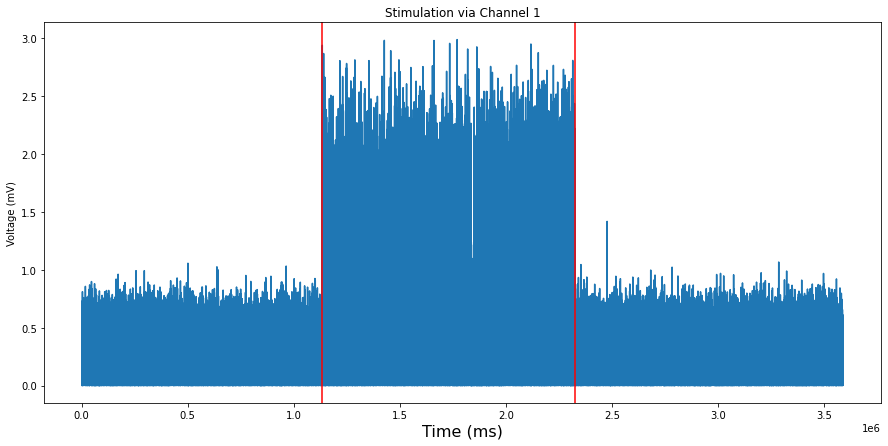

Stimulation starts at 1134444.0 and ends on 2324832.0
Recordings start on 3024.0 and end on 3591192.0


In [35]:

df = import_data('/content/HR18829_210222_200000.csv')

#Visualizing the stimulation
df['CH1'] = df['CH1'].abs()
start = df['ECG_II'].first_valid_index()
stop = df['ECG_II'].last_valid_index()
first_stim = df.where(df['CH1'] >= 2).first_valid_index()
last_stim = df.where(df['CH1'] >= 2).last_valid_index()

print(first_stim, last_stim)
plt.figure(figsize=(15,7))
plt.plot(df.index, df.CH1)
plt.title('Stimulation via Channel 1')
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Voltage (mV)")
plt.axvline(x=first_stim,color='r')
plt.axvline(x=last_stim,color='r')
plt.show()
print("Stimulation starts at "+ str(first_stim) + " and ends on " + str(last_stim))
print( "Recordings start on " + str(start) + " and end on " + str(stop))

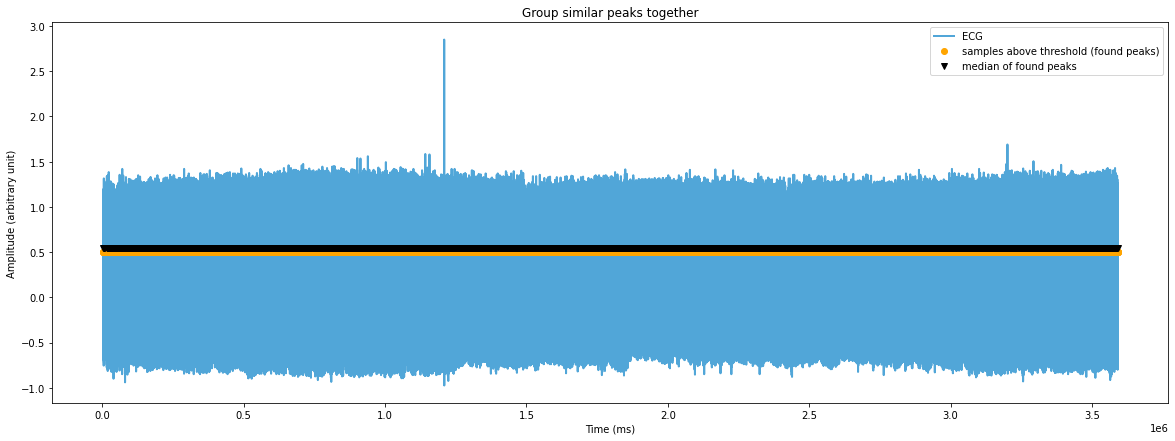

In [36]:
# detect peaks
peaks, similarity = detect_peaks(df.ECG_II[start:stop],threshold=0.5)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks,10)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(df.index, df.ECG_II, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(0.5, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(0.55, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
# uncomment this to make sure that peaks are being correctly detected
# plt.gca().set_xlim(15000,16000)   
plt.show()

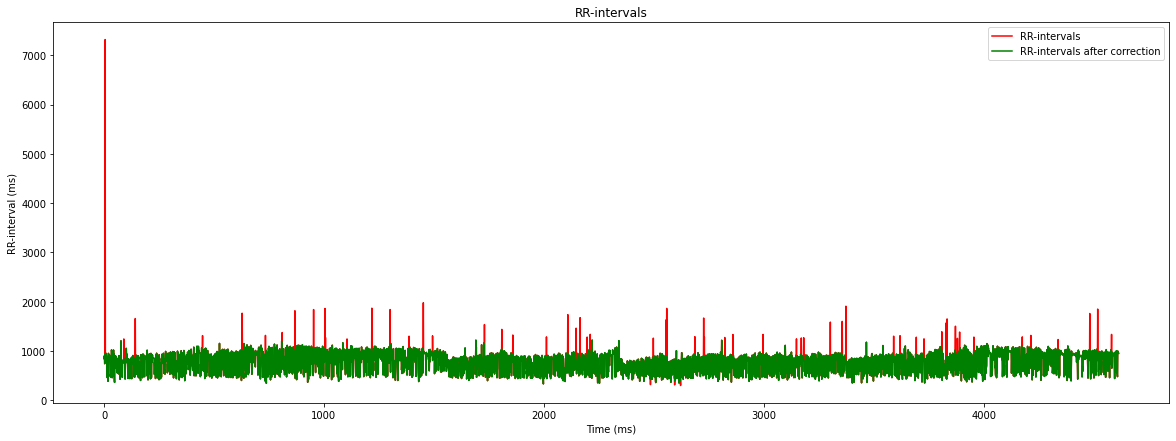

In [37]:
plt.figure(figsize=(20, 7))

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)
#removing any outliers beyond 2 standard deviations
rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

In [38]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [39]:
print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr_corrected).items():
    print("- %s: %.2f" % (k, v))

print()

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 767.99
- STD RR/SDNN (ms): 183.89
- Mean HR (Kubios' style) (beats/min): 78.13
- Mean HR (beats/min): 83.59
- STD HR (beats/min): 23.57
- Min HR (beats/min): 49.02
- Max HR (beats/min): 179.64
- RMSSD (ms): 232.57
- NNxx: 3584.00
- pNNxx (%): 77.66



In [40]:
def full_hrv(df, metric,stim=3):
  df['CH1'] = df['CH1'].abs()
  start = df['ECG_II'].first_valid_index()
  stop = df['ECG_II'].last_valid_index()
  if (df['CH1'] >= 2).any():
    first_stim = df.where(df['CH1'] >= 2).first_valid_index()
    last_stim = df.where(df['CH1'] >= 2).last_valid_index()
    if stim == 1:
      peaks,_ = detect_peaks(df.ECG_II[start:first_stim], threshold=0.5)
    elif stim ==2:
      peaks,_ = detect_peaks(df.ECG_II[first_stim:last_stim], threshold=0.5)
    else:
      peaks,_ = detect_peaks(df.ECG_II[last_stim:stop], threshold=0.5)
  else:
    peaks,_ = detect_peaks(df.ECG_II[start:stop], threshold=0.5)

  grouped_peaks = group_peaks(peaks,10)
  rr = np.diff(grouped_peaks)
  rr[np.abs(zscore(rr)) > 2] = np.median(rr)
  results = timedomain(rr)
  return results[metric]

In [41]:
stim_RMSSD = []
no_RMSSD = []
metric = 'RMSSD (ms)'
filenames = sorted(glob.glob('HR18829*.csv'))
for file in filenames:
  print(file)
  df = import_data(file)
  if (df['CH1'] >= 2).any():
    no_RMSSD.append(full_hrv(df,metric,1))
    no_RMSSD.append(full_hrv(df,metric))
    stim_RMSSD.append(full_hrv(df,metric,2))
  else:
    no_RMSSD.append(full_hrv(df,metric))

print(['%.2f' % item for item in stim_RMSSD])
print(['%.2f' % item for item in no_RMSSD])


HR18829_210222_200000.csv
HR18829_210304_230000.csv
['214.72']
['252.76', '233.01', '152.16']


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 720x504 with 0 Axes>

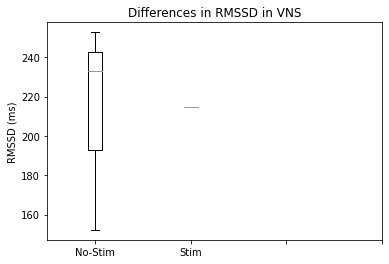

In [42]:
plt.figure(figsize=(10,7))
fig, ax = plt.subplots()
ax.boxplot([no_RMSSD,stim_RMSSD])
plt.xticks([1,2,3,4],['No-Stim', 'Stim'])
plt.ylabel('RMSSD (ms)')
plt.title('Differences in RMSSD in VNS')
plt.show()